/home/haarit/miniconda3/envs/pystt/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Traversed 1067 commits.
Saved 1607 file changes to PDFMathTranslate.csv

Found 13 discrepancies.

# Mismatches by category:
Category
other     9
readme    3
test      1
Name: count, dtype: int64


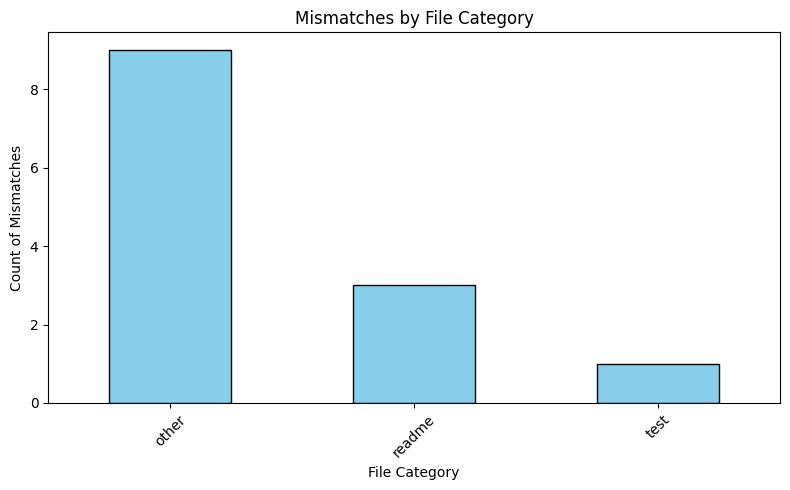


Traversed 1009 commits.
Saved 5513 file changes to flash-attention.csv

Found 33 discrepancies.

# Mismatches by category:
Category
other     28
source     4
test       1
Name: count, dtype: int64


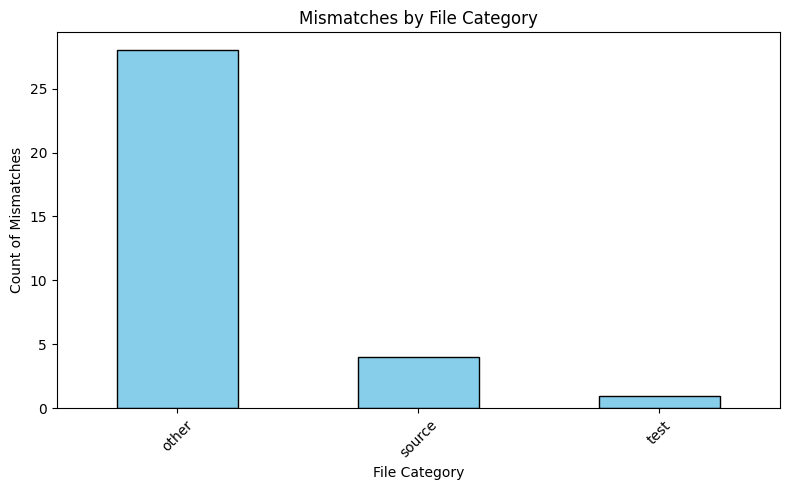


Traversed 2472 commits.
Saved 7796 file changes to ggml.csv

Found 31 discrepancies.

# Mismatches by category:
Category
test      17
other     10
source     3
readme     1
Name: count, dtype: int64


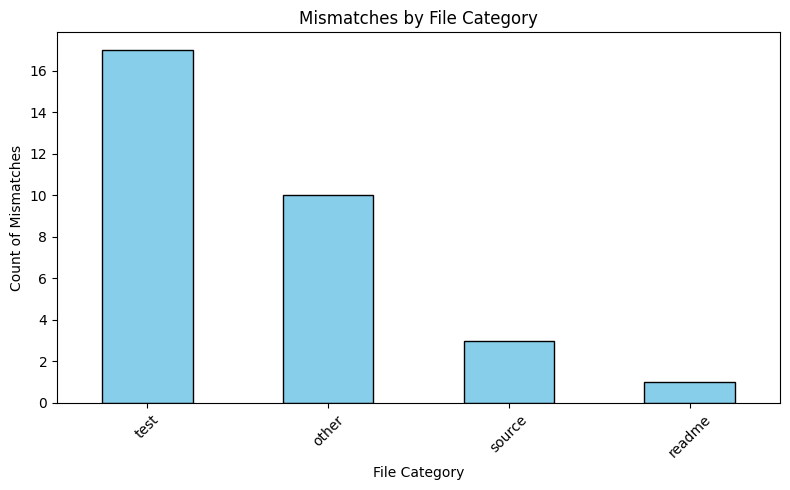

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from pydriller import Repository
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
import re


def myers_diff(repo_path: str, commit_hash: str, parent_hash: str, file_path: str) -> str:
    try:
        result = subprocess.run(
            ["git", "-C", repo_path, "diff", parent_hash, commit_hash, "--", file_path],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            check=True,
            errors="replace"
        )
        lines = result.stdout.splitlines()
        trimmed = []

        keep = False
        for line in lines:
            if line.startswith("@@"):
                keep = True
            if keep:
                trimmed.append(line)

        return "\n".join(trimmed).strip()
    except subprocess.CalledProcessError as e:
        return f"Error getting diff: {e.stderr.strip()}"


def find_filetype(path: str) -> str:
    if not path:
        return "other"
    path_lower = path.lower()
    if "test" in path_lower or "tst" in path_lower:
        return "test"
    if "src" in path_lower or "source" in path_lower:
        return "source"
    if "readme" in path_lower:
        return "readme"
    if "license" in path_lower:
        return "license"
    return "other"


commits_counter = 0


def collect_commit_data(repo_path: str):
    max_commits = int(1e7)
    commit_data = []
    global commits_counter
    total_commits = 0

    for commit in Repository(repo_path, histogram_diff=False).traverse_commits():
        total_commits += 1
        commits_counter += 1

        if max_commits == 0:
            break
        max_commits -= 1

        if not commit.parents:
            continue
        parent_sha = commit.parents[0]

        for file in commit.modified_files:
            old_path = file.old_path
            new_path = file.new_path

            histdiff = file.diff.strip()
            myersdiff = myers_diff(
                repo_path,
                commit.hash,
                parent_sha,
                new_path or old_path
            )

            if histdiff.strip() == "" or myersdiff.strip() == "":
                continue

            isequal = histdiff == myersdiff
            category = find_filetype(new_path or old_path)

            commit_data.append({
                "old_path": old_path,
                "new_path": new_path,
                "commit SHA": commit.hash,
                "parent commit SHA": parent_sha,
                "commit message": commit.msg,
                "diff_hist": histdiff,
                "diff_myers": myersdiff,
                "Discrepancy": not isequal,
                "Category": category
            })

    return commit_data, total_commits





def run_on_url(repo_url):
    commit_data, total_commits = collect_commit_data(repo_url)

    df = pd.DataFrame(commit_data)
    csv_path = f"{repo_url}.csv"
    df.to_csv(csv_path, index=False)

    print(f"\nTraversed {total_commits} commits.")
    print(f"Saved {len(df)} file changes to {csv_path}")

    if "Discrepancy" in df.columns and not df.empty:
        mismatches = df[df["Discrepancy"] == True]
        print(f"\nFound {len(mismatches)} discrepancies.")
        
        if not mismatches.empty:
            stats = mismatches["Category"].value_counts()
            print("\n# Mismatches by category:")
            print(stats)
    else:
        print("\nNo data collected or 'Discrepancy' column not found.")

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,5))
    stats.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title("Mismatches by File Category")
    plt.ylabel("Count of Mismatches")
    plt.xlabel("File Category")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("mismatch_stats.png")
    plt.show()



!git clone https://github.com/Byaidu/PDFMathTranslate.git
!git clone https://github.com/Dao-AILab/flash-attention.git
!git clone https://github.com/ggml-org/ggml.git
run_on_url("PDFMathTranslate")
run_on_url("flash-attention")
run_on_url("ggml")
